**LBP-4:** An illustrative Cash-Flow-At-Risk (CFaR) approach on the example of BMW in the course Fincial Markets and Risk Management.

References:
> Albrecht, P. (2012). *VaR- and CVaR-minimal futures hedging strategies.*  
> Herdegen, M. (2026). Financial Mathematics [Lecture notes]. University of Stuttgart.<br>
> Very Normal. (2024, January 31). *The most important skill in statistics* [Video]. YouTube. https://youtu.be/r7cn3WS5x9c  
> Paolucci, R. (2025, July 29). *Why Monte Carlo simulation works* [Video]. YouTube. https://youtu.be/-4sf43SLL3A



In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf # Yahoo Finance data
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA

**Step 1:**
Calculates the volatility of the EUR/USD exchange rate based on Yahoo Finance Data from the past years. Calculating historical mean via arithmetic mean and ARIMA model, but can more or less be approximated with 0 (thus later usage of just 0).

**Important:** Assumption in this risk measuring approach, that future volatility depends on past volatility.

This must not necessarily hold in practice.

In [ ]:
rates = yf.download(
    "EURUSD=X",
    start="2001-01-01",
    end="2007-01-01",
    interval="1d",
    auto_adjust=False,
    progress=False,
)

fx = rates["Close"].dropna().squeeze()
print("Data range:", fx.index.min(), "->", fx.index.max())

log_returns = np.log(fx).diff().dropna() # Important: Log returns are calculated not standard returns, as suggested in the lecture
daily_vol = log_returns.std()
annualized_vol = daily_vol * np.sqrt(252)
historical_mean = log_returns.mean()

# Tried out with ARIMA to weigh recent returns more, but similar results as with historical, will just round to 0 later
model = ARIMA(log_returns, order=(1,0,0))
res = model.fit()
historical_mean_arima = res.params["const"]


print("Daily volatility:", daily_vol * 100)
print("Annual volatility:", annualized_vol * 100)
print("Historical mean of the exchange rate:", historical_mean)
print("Historical mean ARIMA: ", historical_mean_arima)


Data range: 2003-12-01 00:00:00 -> 2006-12-29 00:00:00


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Daily volatility: 0.5787965921631802
Annual volatility: 9.18811105533271
Historical mean of the exchange rate: 0.000122293229717916
Historical mean ARIMA:  0.00011475688281016289


**Step 2:** Runs the Monte Carlo Simualation with 100.000 simulation runs in order to obtain a precise estimate of the downside risk measure for the EUR cash flow arising from a USD exposure.

**Assumption:** The FX rate follows here a geometric Brownian motion (recommened by many) wth no drift ($\mu=0$). The continiously compounded annual FX return is assumed to be gaussian/normally distributed with mean 0 and the variance being the squared annual volatility of past returns (from Yahoo Finance). Also assuming (for illustrative purposes) that the only thing moving the EUR cash flow is the annual exchange-rate movement, with the USD exposure being fixed and converted at the simulated future spot rate.

This must/does not not necessarily hold in practice.



**Mathematically, this can be expressed as follows:**

Let $S_t$ denote the USD per EUR spot exchange rate. The FX rate is assumed to follow a geometric Brownian motion. Over a one-year horizon $T = 1$, the process is discretized into $M$ equidistant time steps (monthly frequency, $M = 12$), with $\Delta t = T/M$.

The log-return of the FX rate over each time step is given by
$$
\Delta \ln S_m
=
\ln\!\left(\frac{S_{t_m}}{S_{t_{m-1}}}\right)
=
\left(\mu - \tfrac{1}{2}\sigma_{FX}^2\right)\Delta t
+
\sigma_{FX}\sqrt{\Delta t}\, Z_m,
\qquad
Z_m \sim \mathcal{N}(0,1),
$$

The mean parameter is approximated with $\mu = 0$ (due to results above)
and $\sigma_{FX}$ denotes the annualized FX volatility.

Starting from the current spot rate $S_0$, the FX path is obtained recursively as
$$
S_{t_m}
=
S_0
\exp\!\left(
\sum_{k=1}^{m}
\Delta \ln S_k
\right),
\qquad m = 1,\dots,M.
$$

**EUR cash-flow modeling**

Let $\mathrm{USD}_{\text{exp}}$ denote the total annual USD exposure.
The exposure is assumed to be realized evenly throughout the year, resulting in equal monthly cash flows
$$
\mathrm{USD}_m = \frac{\mathrm{USD}_{\text{exp}}}{M},
\qquad m = 1,\dots,M.
$$

For a given simulated FX path $\{S_{t_m}\}_{m=1}^{M}$, the total EUR cash flow over the one-year horizon is given by
$$
CF^{\mathrm{EUR}}
=
\sum_{m=1}^{M}
\frac{\mathrm{USD}_m}{S_{t_m}}
=
\sum_{m=1}^{M}
\frac{\mathrm{USD}_{\text{exp}}/M}{S_{t_m}}.
$$

The baseline EUR cash flow evaluated at today’s spot rate is defined as
$$
CF_0^{\mathrm{EUR}}
=
\frac{\mathrm{USD}_{\text{exp}}}{S_0}.
$$

**Monte Carlo estimation and Cash-Flow-at-Risk**

By repeating the FX path simulation $N$ times, an empirical distribution
$\{CF_i^{\mathrm{EUR}}\}_{i=1}^{N}$ of annual EUR cash flows is obtained.
The expected EUR cash flow is estimated using the Monte Carlo mean,
$$
\mathbb{E}\!\left[CF^{\mathrm{EUR}}\right]
\approx
\frac{1}{N}
\sum_{i=1}^{N}
CF_i^{\mathrm{EUR}}.
$$

The 95\% Cash-Flow-at-Risk (CFaR) is defined as the difference between the expected cash flow
and the lower 5\% quantile of the simulated distribution:
$$
\mathrm{CFaR}_{95\%}
=
\mathbb{E}\!\left[CF^{\mathrm{EUR}}\right]
-
q_{0.05}\!\left(CF^{\mathrm{EUR}}\right),
$$
where $q_{0.05}(\cdot)$ denotes the 5\% lower quantile, corresponding to the worst 5\% of outcomes.

Spot rate for USD per EUR: 1.3198 USD/EUR
[5.23055399e+09 6.35526461e+09 5.84165875e+09 ... 5.84392949e+09
 5.45309570e+09 5.69973430e+09]


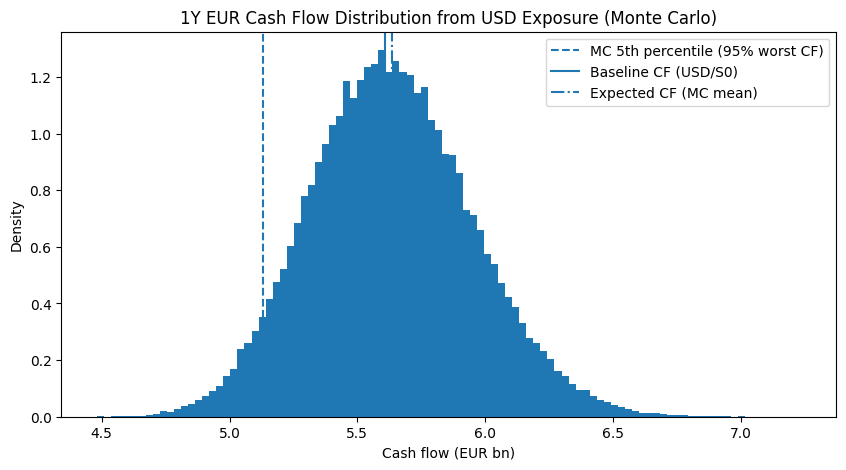

--- Monte Carlo Simulation (1Y CFaR) ---
Baseline EUR CF (USD/S0):              € 5.61 bn
Expected EUR CF (MC mean):             € 5.63 bn
EUR CF 5th percentile (95% worst):     € 5.13 bn
95% CFaR (mean - p5):                  € 0.51 bn

--- Analytical (percentile check) ---
Analytic EUR CF 5th percentile:        € 5.86 bn

----- Difference -----
MC p5 - analytic p5:                   € -0.7298 bn


In [ ]:
usd_exposure = 7.4e9 #Exposure for 2007
fx_vol_annual = annualized_vol
confidence = 0.95
n_simulations = 100_000
steps = 12
dt = 1.0 / steps
alpha = 1 - confidence

S0 = float(fx.iloc[-1]) # USD per EUR
print(f"Spot rate for USD per EUR: {S0:.4f} USD/EUR")

mu_ann = 0.0
mu_ann_historical = historical_mean

usd_cf = np.full(steps, usd_exposure/steps)

# ---------------------------------
# Monte Carlo simulation (One simulation simulates 1-year log return and FX level, but here all in one array)
# ---------------------------------
np.random.seed(42)
z = np.random.normal(size=(n_simulations, steps))
log_increments = (mu_ann - 0.5 * annualized_vol**2) * dt + annualized_vol * np.sqrt(dt) * z
logS = np.log(S0) + np.cumsum(log_increments, axis=1)
S_path = np.exp(logS)

eur_unhedged = np.sum(usd_cf / S_path, axis=1)
eur_base = usd_exposure/S0
eur_mean = eur_unhedged.mean() # According to law of big numbers this should converge to real mean if our economic assumptions hold (do not neccessarily hold in practice)
eur_p5 = np.percentile(eur_unhedged, 100 * alpha)
cfar_95 = eur_mean - eur_p5

# ---------------------------------------------------
# Analytical CFaR for comparison
# ---------------------------------------------------

z_alpha = norm.ppf(alpha)
r_q = (mu_ann - 0.5 * annualized_vol**2) * dt + annualized_vol * np.sqrt(dt) * z_alpha
S_q = S0 * np.exp(r_q)
eur_analytic = usd_exposure / S_q

plt.figure(figsize=(10, 5))
plt.hist(eur_unhedged / 1e9, bins=100, density=True)

plt.axvline(eur_p5 / 1e9, linestyle="--", label="MC 5th percentile (95% worst CF)")
#plt.axvline(eur_analytic / 1e9, linestyle=":", label="Analytical 5th percentile (CF)")
plt.axvline(eur_base / 1e9, linestyle="-", label="Baseline CF (USD/S0)")
plt.axvline(eur_mean / 1e9, linestyle="-.", label="Expected CF (MC mean)")

plt.title("1Y EUR Cash Flow Distribution from USD Exposure (Monte Carlo)")
plt.xlabel("Cash flow (EUR bn)")
plt.ylabel("Density")
plt.legend()
plt.show()

print("--- Monte Carlo Simulation (1Y CFaR) ---")
print(f"Baseline EUR CF (USD/S0):              € {eur_base/1e9:.2f} bn")
print(f"Expected EUR CF (MC mean):             € {eur_mean/1e9:.2f} bn")
print(f"EUR CF 5th percentile (95% worst):     € {eur_p5/1e9:.2f} bn")
print(f"95% CFaR (mean - p5):                  € {cfar_95/1e9:.2f} bn")

print("\n--- Analytical (percentile check) ---")
print(f"Analytic EUR CF 5th percentile:        € {eur_analytic/1e9:.2f} bn")

print("\n----- Difference -----")
print(f"MC p5 - analytic p5:                   € {(eur_p5 - eur_analytic)/1e9:.4f} bn")

**Step 3:** Compare the CFaR in an unhedged state against a hedged state (bounded by a possible risk limit stated by the board). Calculate the optimal hedge ratio (represents kind of a simple constrained optimization problem).

Assumption: As Cash-Flow-At-Risk is being considered for short-term determination of downward risk, the financial products used for hedging in such cases are often ones, that have a linear payoff like forwards or swaps (important for the hedging ratio formula). Thus solving for h, so that in the end only unhedge exposure is being left.


**Mathematically, this can be formulated as follows:**  
The board imposes a risk limit on the 95% Cash-Flow-at-Risk (CFaR), requiring that the downside risk of the EUR cash flow does not exceed a predefined threshold:

$$
\mathrm{CFaR}_{95}^{\mathrm{hedged}} \le \mathrm{Risk\ Limit}.
$$

Let $\mathrm{CFaR}_{95}^{\mathrm{unhedged}}$ denote the 95% CFaR of the unhedged EUR cash flow.  
Assuming linear hedging instruments (e.g. FX forwards), hedging a fraction $h \in [0,1]$ of the USD exposure reduces the residual FX exposure to $(1-h)$. Under this assumption, the hedged CFaR is given by

$$
\mathrm{CFaR}_{95}^{\mathrm{hedged}}
= (1-h)\,\mathrm{CFaR}_{95}^{\mathrm{unhedged}}.
$$

The hedge ratio is chosen as the smallest possible hedge position that satisfies the Board’s risk constraint,

$$
\min_{h}\; h
\quad \text{s.t.} \quad
(1-h)\,\mathrm{CFaR}_{95}^{\mathrm{unhedged}} \le \mathrm{Risk\ Limit},
\quad 0 \le h \le 1.
$$

Imposing the risk limit and solving for $h$ yields the minimum required hedge ratio,

$$
h \ge 1 - \frac{\mathrm{Risk\ Limit}}{\mathrm{CFaR}_{95}^{\mathrm{unhedged}}}.
$$

Given the hedge ratio $h$, the hedged EUR cash flow in each simulation is computed as a linear combination of the hedged and unhedged components (**important:** does not hold for cascade strategy below),

$$
CF_T^{\mathrm{EUR,\,hedged}}
= \mathrm{USD}_{\text{exp}}
\left(
\frac{h}{S_0}
+ \frac{1-h}{S_T}
\right),
$$

where $S_0$ denotes the current spot rate and $S_T$ the simulated future FX rate.

Repeating the simulation yields the empirical distribution of the hedged cash flow. The expected hedged cash flow and the corresponding 95% CFaR are estimated as

$$
\mathbb{E}\!\left[CF_T^{\mathrm{EUR,\,hedged}}\right]
\approx \frac{1}{N}\sum_{i=1}^{N} CF_{T,i}^{\mathrm{EUR,\,hedged}},
$$

$$
\mathrm{CFaR}_{95}^{\mathrm{hedged}}
= \mathbb{E}\!\left[CF_T^{\mathrm{EUR,\,hedged}}\right]
- \mathrm{Quantile}_{5\%}\!\left(CF_T^{\mathrm{EUR,\,hedged}}\right).
$$


Unhedged 95% CFaR:                      € 0.51 bn
Risk limit:                             € 300 m
Required hedge ratio h:                 40.63%
Hedged 95% CFaR:                        € 300.0 m


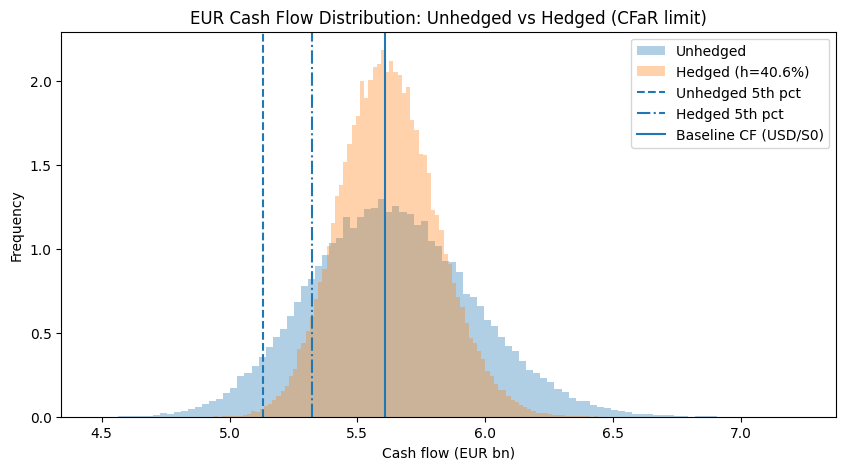

In [ ]:
risk_limit = 300e6
cfar0 = cfar_95
h_required = max(0.0, min(1.0, 1.0 - risk_limit / cfar0))
h = h_required

eur_cf_hedged = h * eur_base + (1.0 - h) * eur_unhedged

eur_mean_hedged = eur_cf_hedged.mean()
eur_p5_hedged   = np.percentile(eur_cf_hedged, 100 * alpha)
cfar_95_hedged  = eur_mean_hedged - eur_p5_hedged

print(f"Unhedged 95% CFaR:                      € {cfar0/1e9:.2f} bn")
print(f"Risk limit:                             € {risk_limit/1e6:.0f} m")
print(f"Required hedge ratio h:                 {h_required:.2%}")
print(f"Hedged 95% CFaR:                        € {cfar_95_hedged/1e6:.1f} m")

plt.figure(figsize=(10, 5))
plt.hist(eur_unhedged / 1e9, bins=100, density=True, alpha=0.35, label="Unhedged")
plt.hist(eur_cf_hedged / 1e9, bins=100, density=True, alpha=0.35, label=f"Hedged (h={h_required:.1%})")

plt.axvline(np.percentile(eur_unhedged, 100 * alpha) / 1e9, linestyle="--", label="Unhedged 5th pct")
plt.axvline(eur_p5_hedged / 1e9, linestyle="dashdot", label="Hedged 5th pct")
plt.axvline(eur_base / 1e9, linestyle="-", label="Baseline CF (USD/S0)")

plt.title("EUR Cash Flow Distribution: Unhedged vs Hedged (CFaR limit)")
plt.xlabel("Cash flow (EUR bn)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


S0 = 1.3198 USD/EUR
Unhedged: mean=5.63, p5=5.13, CFaR95=0.51
Hedged:   mean=5.62, p5=5.33, CFaR95=0.29


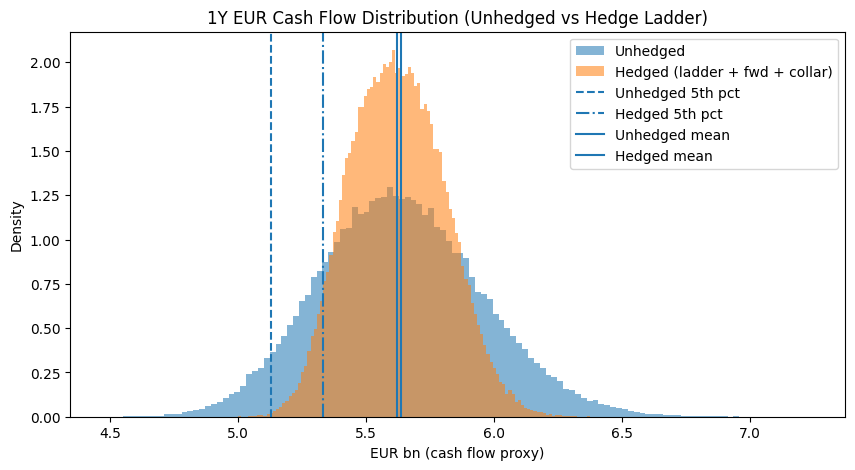

In [ ]:
usd_exposure_annual = 7.4e9
sigma_ann = annualized_vol
mu_ann = 0.0
confidence = 0.95
risk_limit = 300e6
alpha = 1 - confidence

n_simulations = 100_000
steps = 12
dt = 1.0 / steps

S0 = float(fx.iloc[-1])  # USD per EUR
print(f"S0 = {S0:.4f} USD/EUR")

usd_cf = np.full(steps, usd_exposure_annual / steps)

# ----------------------------------
# Hedge ladder
# ----------------------------------
h_by_month = np.array([
    0.85, 0.80, 0.75,
    0.70, 0.65, 0.60,
    0.55, 0.50, 0.45,
    0.40, 0.35, 0.30
])

forward_share = 0.70
collar_share = 0.30

K_by_month = np.full(steps, S0)

x0 = 1.0 / S0
x_floor = x0 * 0.95
x_cap   = x0 * 1.05

def eur_from_collar(usd_amount, S, x_floor, x_cap):
    x = 1.0 / S
    x_eff = np.minimum(np.maximum(x, x_floor), x_cap)
    return usd_amount * x_eff

def cfar(samples, confidence=0.95):
    a = 1 - confidence
    mean_ = samples.mean()
    pctl_ = np.percentile(samples, 100 * a)
    return mean_, pctl_, (mean_ - pctl_)

# ----------------------------------
# Simulates monthly FX paths (GBM)
# ----------------------------------
np.random.seed(42)
Z = np.random.normal(size=(n_simulations, steps))
log_increments = (mu_ann - 0.5 * sigma_ann**2) * dt + sigma_ann * np.sqrt(dt) * Z
logS = np.log(S0) + np.cumsum(log_increments, axis=1)
S_path = np.exp(logS)

# ----------------------------------
# Aggregates cash flows
# ----------------------------------
eur_unhedged = np.zeros(n_simulations)
eur_hedged = np.zeros(n_simulations)

for m in range(steps):
    S_m = S_path[:, m]
    usd_m = usd_cf[m]
    h_m = h_by_month[m]

    # Unhedged spot conversion
    eur_spot = usd_m / S_m
    eur_unhedged += eur_spot

    # Hedged split
    usd_hedged = h_m * usd_m
    usd_fwd = forward_share * usd_hedged
    usd_col = collar_share * usd_hedged
    usd_open = usd_m - usd_hedged

    eur_fwd = usd_fwd / K_by_month[m]
    eur_col = eur_from_collar(usd_col, S_m, x_floor, x_cap)
    eur_open = usd_open / S_m

    eur_hedged += (eur_fwd + eur_col + eur_open)

mean_u, p5_u, cfar_u = cfar(eur_unhedged, confidence)
mean_h, p5_h, cfar_h = cfar(eur_hedged, confidence)

print(f"Unhedged: mean={mean_u/1e9:.2f}, p5={p5_u/1e9:.2f}, CFaR95={cfar_u/1e9:.2f}")
print(f"Hedged:   mean={mean_h/1e9:.2f}, p5={p5_h/1e9:.2f}, CFaR95={cfar_h/1e9:.2f}")

plt.figure(figsize=(10, 5))
plt.hist(eur_unhedged / 1e9, bins=120, density=True, alpha=0.55, label="Unhedged")
plt.hist(eur_hedged / 1e9, bins=120, density=True, alpha=0.55, label="Hedged (ladder + fwd + collar)")

plt.axvline(p5_u / 1e9, linestyle="--", label="Unhedged 5th pct")
plt.axvline(p5_h / 1e9, linestyle="-.", label="Hedged 5th pct")
plt.axvline(mean_u / 1e9, linestyle="-", label="Unhedged mean")
plt.axvline(mean_h / 1e9, linestyle="-", label="Hedged mean")

plt.title("1Y EUR Cash Flow Distribution (Unhedged vs Hedge Ladder)")
plt.xlabel("EUR bn (cash flow proxy)")
plt.ylabel("Density")
plt.legend()
plt.show()
